In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')


path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/data/preprocessedData'

In [2]:
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')
X_val = pd.read_csv(path + '/X_val.csv')
y_val = pd.read_csv(path + '/y_val.csv')
test = pd.read_csv(path + '/test.csv')

In [3]:
#Reshape
image_col = 28
image_row = 28
X_train1 = X_train.values.reshape(X_train.shape[0],image_col,image_row,1)
X_val1 = X_val.values.reshape(X_val.shape[0],image_col,image_row,1)
test1 = test.values.reshape(test.shape[0],image_col,image_row,1)
X_train1.shape,X_val1.shape,test1.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (28000, 28, 28, 1))

In [4]:
# Label Encoding (# convert label to one-hot-encoding)
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y_train1 = to_categorical(y_train, num_classes = 10)
y_val1 = to_categorical(y_val, num_classes = 10)
y_train1.shape,y_val1.shape

((37800, 10), (4200, 10))

ResNet18

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Add, Activation,GlobalAveragePooling2D,Flatten
class ResNetBlock(Model):

    def __init__(self, filter_num, strides=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = Conv2D(filter_num, (3,3), strides=strides, padding="same")
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding="same")
        self.bn2 = BatchNormalization()

        """
        Adds a shortcut between input and residual block and merges them with "sum"
        """
        if strides != 1:
            self.shortcut = Sequential()
            self.shortcut.add(Conv2D(filter_num, (1,1), strides=strides,padding="same"))
            self.shortcut.add(BatchNormalization())
        else:
            self.shortcut = lambda x: x

    def call(self, x, training=None):
        residual = self.shortcut(x)

        conv1 = self.conv1(x)
        #print('after conv1',conv1.shape)
        bn1 = self.bn1(conv1)
        relu1 = self.relu(bn1)
        conv2 = self.conv2(relu1)
        #print('after conv2',conv2.shape)
        bn2 = self.bn2(conv2)

        #print(residual.shape,bn2.shape)
        out = tf.nn.relu(tf.keras.layers.add([residual, bn2]))
        return out


In [6]:
class ResNet(Model):
  def __init__(self, layer_dims, num_classes=10):   #layer_dims [2,2,2,2] means 4 layer in total and 2 resnetblock in each layer
    super(ResNet,self).__init__()

    #preprocessing layer
    self.stem = Sequential([Conv2D(64,(3,3),strides=1,padding="same"),
                            BatchNormalization(),
                            Activation('relu'),
                            MaxPool2D(pool_size=(2,2),strides=1,padding='same')
                            ])
    
    # resnet blocks
    self.layer1 = self.build_resblock(64,layer_dims[0])
    self.layer2 = self.build_resblock(128,layer_dims[1],stride=2)
    self.layer3 = self.build_resblock(256,layer_dims[2],stride=2)
    self.layer4 = self.build_resblock(512,layer_dims[3],stride=2)
    
    # output: [b, 512, h, w]
    self.avgpool = GlobalAveragePooling2D()

    # fc layer
    self.fc = Dense(num_classes,activation='softmax')

  def call(self, x, training=None):
    out = self.stem(x)

    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)

    out = self.avgpool(out)

    out = self.fc(out)
    
    return out

  def build_resblock(self, filter_num, blocks, stride=1):    #blocks: how many basic blocks
    res_blocks = Sequential()
    # may down sample
    res_blocks.add(ResNetBlock(filter_num,stride))

    for _ in range(1, blocks):
      res_blocks.add(ResNetBlock(filter_num,stride))

    return res_blocks

In [7]:
def ResNet18():
  return ResNet([2,2,2,2],num_classes=10)

In [8]:
lr = 0.0001
batch_size = 32
EPOCHS = 50

# Build your model here
model = ResNet18()
optimizer = tf.keras.optimizers.Adam(lr)

In [9]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [29]:
#Checkpoint
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/resnet18/resnet.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True)      

In [30]:
history = model.fit(X_train1, y_train1, batch_size=32, epochs=EPOCHS, validation_data=(X_val1, y_val1),callbacks=[cp_callback])

Epoch 1/50
1182/1182 [==============================] - ETA: 0s - loss: 0.2248 - categorical_accuracy: 0.9288
Epoch 00001: val_loss improved from inf to 0.09714, saving model to /content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/resnet18/resnet.ckpt
1182/1182 [==============================] - 40s 34ms/step - loss: 0.2248 - categorical_accuracy: 0.9288 - val_loss: 0.0971 - val_categorical_accuracy: 0.9690
Epoch 2/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0711 - categorical_accuracy: 0.9782
Epoch 00002: val_loss improved from 0.09714 to 0.05583, saving model to /content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/resnet18/resnet.ckpt
1182/1182 [==============================] - 39s 33ms/step - loss: 0.0711 - categorical_accuracy: 0.9782 - val_loss: 0.0558 - val_categorical_accuracy: 0.9819
Epoch 3/50
1181/1182 [============================>.] - ETA: 0s - loss: 0.0501 - categorical_accuracy: 0.9844
Epoch 00003: val_loss did not impr

In [31]:
model.summary()

Model: "res_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_22 (Sequential)   (None, 28, 28, 64)        896       
_________________________________________________________________
sequential_23 (Sequential)   (None, 28, 28, 64)        148736    
_________________________________________________________________
sequential_24 (Sequential)   (None, 7, 7, 128)         544512    
_________________________________________________________________
sequential_27 (Sequential)   (None, 2, 2, 256)         2170368   
_________________________________________________________________
sequential_30 (Sequential)   (None, 1, 1, 512)         8666112   
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  51

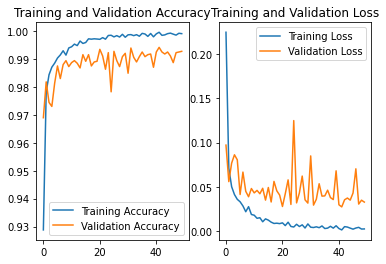

In [32]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [34]:
predictions = model.predict(test1, verbose=0)
#print(predictions)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": np.argmax(predictions,axis=1)})
submissions.to_csv("resnet18.csv", index=False, header=True)

In [35]:
print(np.argmax(predictions,axis=1)[:50])

[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7]


In [10]:
#load weights from checkpoint
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/resnet18/resnet.ckpt'
model.load_weights(checkpoint_path)

In [13]:
predictions = model.predict(test1, verbose=0)
#print(predictions)

print(np.argmax(predictions,axis=1)[:50])

[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7]


In [ ]:
 !kaggle competitions submit -c digit-recognizer -f resnet18.csv -m "resnet18 result"

100% 208k/208k [00:00<00:00, 377kB/s]
Successfully submitted to Digit Recognizer